<a href="https://colab.research.google.com/github/marcochisci/Anomaly_detection/blob/main/1day_1month_AnomalyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airquino table Data
Average data values (every day) of a month ( August 2021)

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,
2021-08-01,384.235546,4.076017,403.937901,39.882377,26.566274,12.859743,639.796574,196.073876,239.584582,334.202355
2021-08-02,328.395048,2.674919,408.648009,37.508095,24.416039,11.033369,583.980624,209.952637,221.217438,322.712594
2021-08-03,335.829947,1.801070,414.223529,36.878930,23.685989,6.512299,603.807487,205.767914,222.709091,324.391444
2021-08-04,363.098676,2.317690,413.270758,38.291865,24.596871,7.028881,616.511432,224.625752,227.711191,332.073406
2021-08-05,357.354193,2.529412,406.629537,37.626408,24.007384,10.163955,695.724656,220.449312,238.334168,326.675845
2021-08-06,368.779956,2.891068,418.057734,38.071035,24.360784,11.481481,680.343137,254.114379,232.639434,334.448802
2021-08-07,417.820043,2.076509,422.089440,39.623427,26.203341,6.691810,630.110991,284.343750,231.670259,355.187500
2021-08-08,401.059638,1.799787,425.652822,40.257604,26.788498,5.138445,529.003195,270.791267,223.179979,357.536741
2021-08-09,389.940412,1.444204,419.832069,39.128570,26.490141,5.063922,479.530878,242.198267,221.241603,355.403034


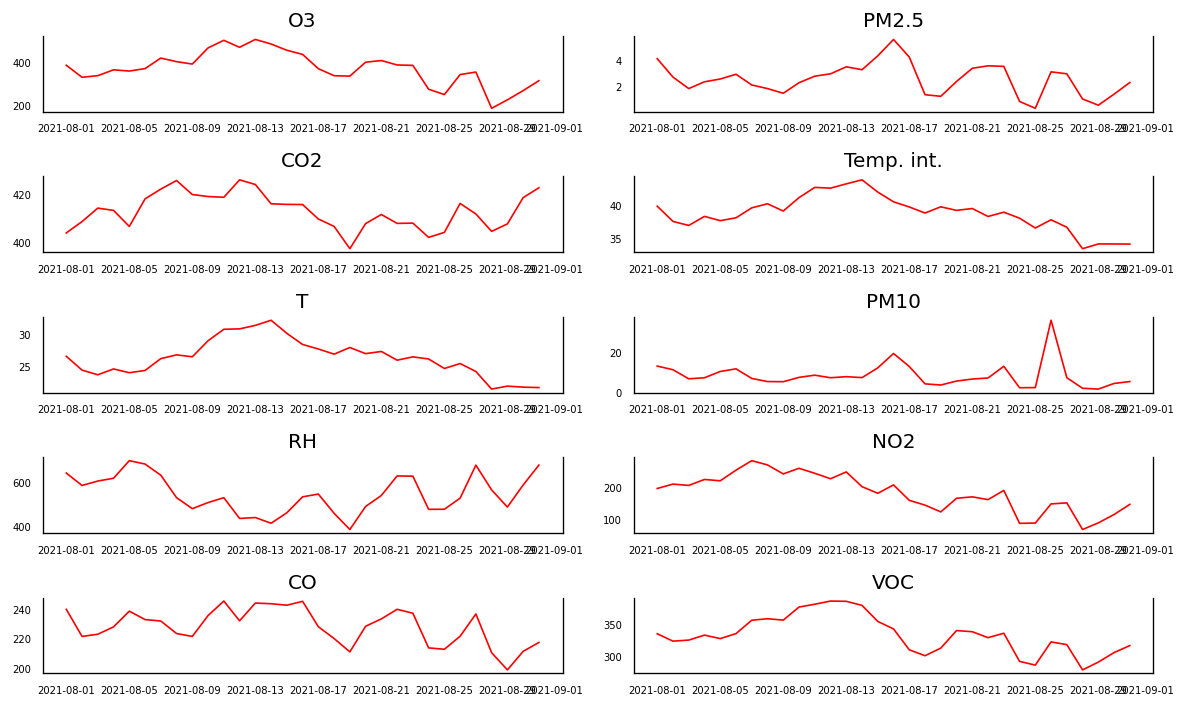

In [1]:
import pandas as pd
import psycopg2
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import numpy as np
%matplotlib inline


conn = psycopg2.connect(host='playground.magentalab.it', port='55432', database='airqino', user='datareader', password='homntLZnlhQd9prtVA9SFezQek')

query=""" select time_bucket('1 day', c."Dates" ) as "bucket", avg(c."O3") as "O3" ,  avg(c."PM2.5") as "PM2.5", avg(c."CO2") as "CO2",
 avg(c."Temp. int.") as "Temp. int.",  avg(c."T") as "T",  avg(c."PM10") as "PM10", avg(c."RH") as "RH", avg(c."NO2") as 
 "NO2", avg(c."CO") as "CO", avg(c."VOC") as "VOC"
from (select * from crosstab(
  'select sd.data_acquired as timestamp, s.sensor_type ,  sd.float_value as value 
from station_data sd join sensor s on s.id = sd.sensor_id
where sd.data_acquired >= to_timestamp(''2021-08-01 00:00:00'', ''YYYY-mm-dd HH24:MI:SS'')
 and sd.data_acquired < to_timestamp(''2021-09-01 00:00:00'', ''YYYY-mm-dd HH24:MI:SS'')
and sd.station_id = 23284701 order by sd.data_acquired asc, 1'
 , $$VALUES ('O3'::varchar), ('PM2.5'::varchar), ('CO2'::varchar), ('Temp. int.'::varchar), ('T'::varchar)
 , ('PM10'::varchar), ('RH'::varchar), ('NO2'::varchar), ('CO'::varchar), ('VOC'::varchar)$$
) AS value ("Dates" timestamp, "O3" float, "PM2.5" float, "CO2" float, "Temp. int." float, "T" float, "PM10" float,
"RH" float, "NO2" float, "CO" float, "VOC" float))  c 
group by bucket
order by bucket asc;
 """
df = pd.read_sql(query, conn)
df= df.rename(columns={'bucket': 'Dates'})
df=df.set_index('Dates')
#fix temp int
df['Temp. int.'] = df['Temp. int.'].div(100)
df['T'] = df['T'].div(10)

display(df)

# Plot
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

# Testing stationarity 

In [7]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(ts_data, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(ts_data, autolag='AIC')
    else:
        adf_test = adfuller(ts_data[column], autolag='AIC')
    p_value = adf_test[1]                   
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result

adf_test_results = {
    col: test_stationarity(df, col)
    for col in df.columns
}
adf_test_results     

{'CO': 'Stationary',
 'CO2': 'Stationary',
 'NO2': 'Stationary',
 'O3': 'Stationary',
 'PM10': 'Stationary',
 'PM2.5': 'Stationary',
 'RH': 'Stationary',
 'T': 'Stationary',
 'Temp. int.': 'Stationary',
 'VOC': 'Stationary'}

Converting to stationary with differencing

In [3]:
#before the first differencing
df_copy= df.copy()

In [6]:
def differencing(data, column, order):
    differenced_data = data[column].diff(order)
    differenced_data.fillna(differenced_data.mean(), inplace=True)
    return differenced_data
for col in df.columns:
    df[col] = differencing(df, col, 1)

Test for stationarity now

# VAR model

Finding the best lag for VAR model (if the max_lag value is too high the model may not work)

In [10]:
from statsmodels.tsa.api import VAR
max_lag = 1
var_model = VAR(df)
# select the best lag order
lag_results = var_model.select_order(max_lag)
selected_lag = lag_results.aic
print(selected_lag)

1


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Finding anomalies

In [11]:
import numpy as np
import scipy as sp

#mahalanobis distance
def mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = sp.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()
  
#0 means that is it not an anomaly
def find_anomalies(errors):
    threshold = np.mean(errors) + np.std(errors)
    predictions = (errors >= threshold).astype(int)
    return predictions, threshold
var = VAR(df)
var_fitresults = var.fit(selected_lag)
var_fit_df=pd.DataFrame(var_fitresults.fittedvalues, index=df_copy.index[-(len(df_copy)-selected_lag):], columns=df.columns)
errors = mahalanobis(x=var_fit_df, data= df)
errors_df=pd.DataFrame(errors, index=df_copy.index[-(len(df_copy)-selected_lag):])
predictions, threshold = find_anomalies(errors_df)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [12]:
data = df_copy.iloc[selected_lag:, :]
data['Predictions'] = predictions.values
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions
Dates,,,,,,,,,,,
2021-08-02,328.395048,2.674919,408.648009,37.508095,24.416039,11.033369,583.980624,209.952637,221.217438,322.712594,0
2021-08-03,335.829947,1.801070,414.223529,36.878930,23.685989,6.512299,603.807487,205.767914,222.709091,324.391444,0
2021-08-04,363.098676,2.317690,413.270758,38.291865,24.596871,7.028881,616.511432,224.625752,227.711191,332.073406,0
2021-08-05,357.354193,2.529412,406.629537,37.626408,24.007384,10.163955,695.724656,220.449312,238.334168,326.675845,0
2021-08-06,368.779956,2.891068,418.057734,38.071035,24.360784,11.481481,680.343137,254.114379,232.639434,334.448802,0
2021-08-07,417.820043,2.076509,422.089440,39.623427,26.203341,6.691810,630.110991,284.343750,231.670259,355.187500,0
2021-08-08,401.059638,1.799787,425.652822,40.257604,26.788498,5.138445,529.003195,270.791267,223.179979,357.536741,0
2021-08-09,389.940412,1.444204,419.832069,39.128570,26.490141,5.063922,479.530878,242.198267,221.241603,355.403034,0
2021-08-10,465.185027,2.247059,419.014973,41.217048,28.990053,7.220321,507.050267,260.093048,235.383957,375.645989,0


In [13]:
data['Predictions'].value_counts()

0    26
1     4
Name: Predictions, dtype: int64

# Showing the anomalies found with Mahalanobis distance

The anomaly is shown with the 3 previous values, all the following anomalous values and the following 2 non-anomalous values

> The first anomaly is always the 4-th row



Diplay all the anomalies

In [15]:
index_no = data.columns.get_loc('Predictions')
i=0
while(i<len(data)):
  if(data.iloc[[i],[index_no]].values == 1):
    j=i+1
    if(j>=len(data)):
      break
    else:
       while(data.iloc[[j],[index_no]].values == 1):
          j=j+1
          if(j>=len(data)):
            j=j-1
            break
    for s in range(i,j):
      d=0
      for col in df.columns:
        dis=float(data.iloc[[s],[d]].values-data.iloc[[s-1],[d]].values)
        print(col+':'+str(dis))
        d=d+1
      print ('*' * 20)
    if(i-3<0):
      tmp=data.iloc[i: j + 2]
      display(tmp)
    if(j+2>len(data)):
      tmp=data.iloc[i -3: j]
      display(tmp)
    else:
      tmp=data.iloc[i - 3 : j + 2]
      display(tmp)
    i=j
  else:
    i=i+1     

O3:-1.790190669030892
PM2.5:-0.11883785792675683
CO2:-9.238554149492131
Temp. int.:0.9704118618832069
T:1.0338399666335008
PM10:-0.5747542366365077
RH:-72.89151927078359
NO2:-21.471410130646603
CO:-9.037609542072772
VOC:11.820592162135085
********************


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions
Dates,,,,,,,,,,,
2021-08-16,434.901622,5.541622,415.702703,40.566508,28.407027,19.134054,532.820541,207.422703,245.014054,341.694054,0
2021-08-17,368.459796,4.197055,409.710079,39.761087,27.701472,12.651189,545.185730,158.468856,227.792752,309.306908,0
2021-08-18,335.669206,1.332971,406.653972,38.816355,26.899565,3.988030,458.645267,143.219804,219.808487,300.104461,0
2021-08-19,333.879015,1.214133,397.415418,39.786767,27.933405,3.413276,385.753747,121.748394,210.770878,311.925054,1
2021-08-20,398.658940,2.343267,407.814570,39.227417,26.979470,5.383002,489.341060,165.024283,228.123620,339.185430,0
2021-08-21,406.313616,3.343750,411.579241,39.519888,27.316741,6.389509,538.996652,169.441964,233.104911,337.362723,0


O3:-168.77959359706438
PM2.5:-1.9186853002700985
CO2:-7.207630014704989
Temp. int.:-3.344408054960283
T:-2.7410581729533305
PM10:-5.266859240434155
RH:-111.57521402612781
NO2:-84.42218488787309
CO:-26.234896949480458
VOC:-39.17894984350846
********************
O3:39.38786122415425
PM2.5:-0.47291075759444245
CO2:3.0959222263329025
Temp. int.:0.7415585563365781
T:0.45924487195297203
PM10:-0.41221687836560195
RH:-77.05944012825262
NO2:21.019648949726644
CO:-11.637707074444052
VOC:12.116927693509297
********************
O3:43.001223576517674
PM2.5:0.8413578284166519
CO2:10.878091032208658
Temp. int.:-0.004482046752627866
T:-0.15430477536359888
PM10:2.8133639521874816
RH:99.3425189895778
NO2:26.506259200376846
CO:12.551413766707896
VOC:14.768105752811607
********************


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions
Dates,,,,,,,,,,,
2021-08-25,247.870787,0.299625,404.157303,36.477772,24.667228,2.121723,476.782772,86.338951,212.514981,285.533708,0
2021-08-26,341.027344,3.074219,416.156250,37.761367,25.437891,35.726206,527.014323,147.105469,221.369792,321.555990,0
2021-08-27,352.658617,2.926454,411.792536,36.600834,24.200659,7.055982,675.373216,150.361142,236.435785,317.276619,0
2021-08-28,183.879023,1.007769,404.584906,33.256426,21.459600,1.789123,563.798002,65.938957,210.200888,278.097669,1
2021-08-29,223.266885,0.534858,407.680828,33.997985,21.918845,1.376906,486.738562,86.958606,198.563181,290.214597,1
2021-08-30,266.268108,1.376216,418.558919,33.993503,21.764541,4.190270,586.081081,113.464865,211.114595,304.982703,1


Witch anamaly do you want to display? (enter a number)

In [20]:
input_a =int(input("Type the number of the anomaly you want to display:"))
index_no = data.columns.get_loc('Predictions')
cnt=0
i=0
while(i<len(data)):
  if(data.iloc[[i],[index_no]].values == 1):
    cnt=cnt+1
    j=i+1
    while(data.iloc[[j],[index_no]].values == 1):
      j=j+1
    if(input_a == cnt):
      for s in range(i,j):
        d=0
        for col in df.columns:
          dis=float(data.iloc[[s],[d]].values-data.iloc[[s-1],[d]].values)
          print(col+':'+str(dis))
          d=d+1
      print ('*' * 20)
      if(i-3<0):
        tmp=data.iloc[i: j + 2]
        display(tmp)
      if(j+2>len(data)):
        tmp=data.iloc[i-2: j]
        display(tmp)
      else:
        tmp=data.iloc[i - 3 : j + 2]
        display(tmp)
      i=len(data+1)
    i=j
  else:
    i=i+1   


Type the number of the anomaly you want to display:2
O3:-168.77959359706438
PM2.5:-1.9186853002700985
CO2:-7.207630014704989
Temp. int.:-3.344408054960283
T:-2.7410581729533305
PM10:-5.266859240434155
RH:-111.57521402612781
NO2:-84.42218488787309
CO:-26.234896949480458
VOC:-39.17894984350846
O3:39.38786122415425
PM2.5:-0.47291075759444245
CO2:3.0959222263329025
Temp. int.:0.7415585563365781
T:0.45924487195297203
PM10:-0.41221687836560195
RH:-77.05944012825262
NO2:21.019648949726644
CO:-11.637707074444052
VOC:12.116927693509297
O3:43.001223576517674
PM2.5:0.8413578284166519
CO2:10.878091032208658
Temp. int.:-0.004482046752627866
T:-0.15430477536359888
PM10:2.8133639521874816
RH:99.3425189895778
NO2:26.506259200376846
CO:12.551413766707896
VOC:14.768105752811607
********************


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions
Dates,,,,,,,,,,,
2021-08-26,341.027344,3.074219,416.156250,37.761367,25.437891,35.726206,527.014323,147.105469,221.369792,321.555990,0
2021-08-27,352.658617,2.926454,411.792536,36.600834,24.200659,7.055982,675.373216,150.361142,236.435785,317.276619,0
2021-08-28,183.879023,1.007769,404.584906,33.256426,21.459600,1.789123,563.798002,65.938957,210.200888,278.097669,1
2021-08-29,223.266885,0.534858,407.680828,33.997985,21.918845,1.376906,486.738562,86.958606,198.563181,290.214597,1
2021-08-30,266.268108,1.376216,418.558919,33.993503,21.764541,4.190270,586.081081,113.464865,211.114595,304.982703,1


# Searching the anomalies using distance from the var model expected values

In [21]:
var_fit_df=pd.DataFrame(var_fitresults.fittedvalues, index=df_copy.index[-(len(df_copy)-selected_lag):], columns=df.columns)



In [22]:
#var expected values into a df
var_fit_df=pd.DataFrame(var_fitresults.fittedvalues, index=df_copy.index[-(len(df_copy)-selected_lag):], columns=df.columns)

#revert the differencing
df_tra= df_copy[0:-selected_lag]
def invert_transformation(df_train, df, second_diff=False):
    """Revert back the differencing to original scale."""
    df_fc = df.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)] = df_train[col].iloc[-1] + df_fc[str(col)].cumsum()
    return df_fc
res = invert_transformation(df_tra, var_fit_df, second_diff=False)
display(res)     


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,
2021-08-02,268.021172,1.396640,418.862062,33.989113,21.755334,4.261325,590.097568,114.765241,211.565936,305.505028
2021-08-03,309.177317,0.889818,420.890446,35.816131,23.497112,6.542867,541.549523,117.617632,212.331180,316.968989
2021-08-04,271.772338,1.721763,419.022627,34.598630,22.346076,6.294755,552.172188,125.501200,209.138619,310.100059
2021-08-05,219.070456,0.797736,414.869237,32.609331,20.733858,4.646335,570.523198,77.351726,204.274373,293.248250
2021-08-06,259.124130,1.363644,421.771089,34.220281,21.948963,6.370401,558.009676,111.926908,201.584133,306.815033
2021-08-07,263.489466,0.535656,413.916289,33.804183,21.744971,-1.416495,595.925754,89.784395,213.393363,297.074825
2021-08-08,264.289145,1.395201,417.584894,34.353693,22.039088,1.759173,596.460367,80.183799,213.796898,299.885257
2021-08-09,291.195592,2.213622,415.125949,33.386332,21.223022,7.348272,656.885585,120.377007,219.711135,308.878370
2021-08-10,361.417573,3.779673,427.661925,35.272764,22.439081,10.233303,740.212470,179.351666,231.999170,331.919046


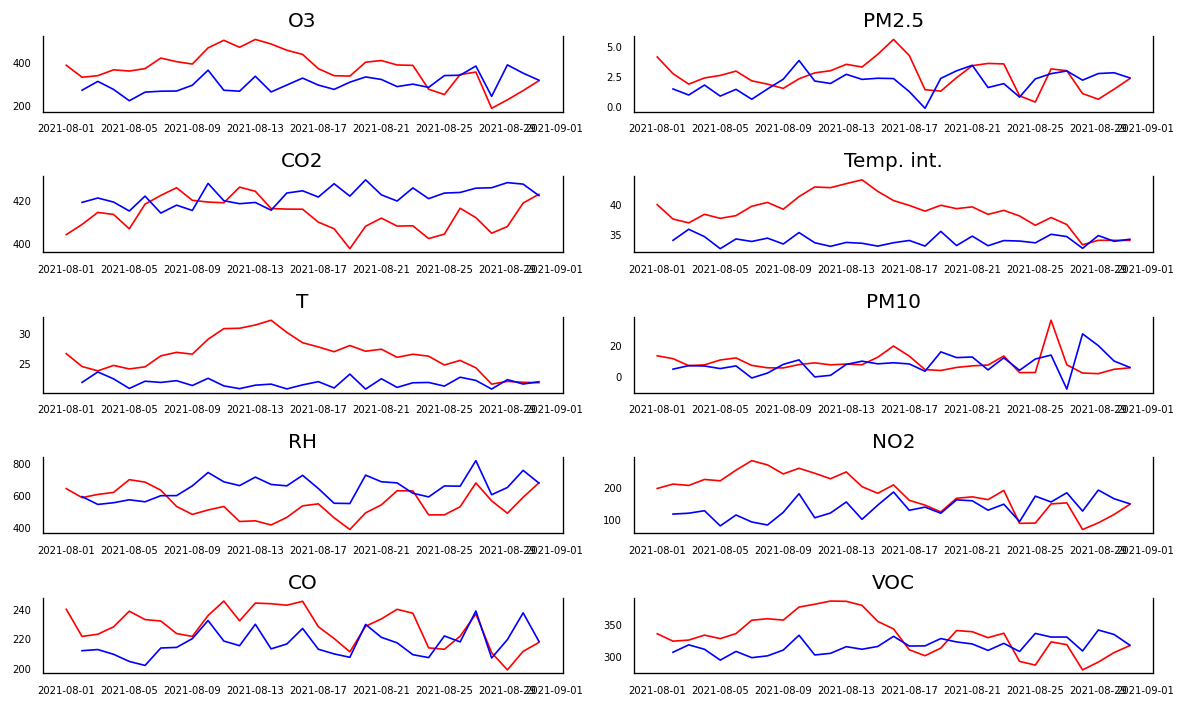

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Plot
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data_2 = df_copy[df.columns[i]]
    data_res=res[res.columns[i]]
    ax.plot(data_2, color='red', linewidth=1)
    ax.plot(data_res, color='blue', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

Define a threshold: if the value is farther from the prediction than the mean ditance of the actual value from the prediction +10% of the prediction scale it is an anomaly

In [24]:
import numpy as np
#define threshold for all the columns
distance = pd.DataFrame()
threshold=[]
scale= []
mean=[]
usable = df_copy.iloc[selected_lag:, :]
for col in df.columns:
  distance[col]=(usable[col]).values-(res[col]).values
  mean.append(distance[col].mean())
  scale.append(usable[col].values.max()-usable[col].values.min())
for i in range(len(mean)):
  threshold.append(mean[i]+0.6*scale[i])
#find where the threshold is not respected
i=0
list_rows=[]
for col in df.columns:
  for j in range(len(usable)):
    if(abs((usable.iloc[[j],[i]].values-res.iloc[[j],[i]].values))>threshold[i]):
      list_rows.append(j)
  i=i+1
usable['Predictions']=0
index = usable.columns.get_loc('Predictions')
for i in range(len(list_rows)):
  usable.iloc[[list_rows[i]],[index]]=1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


Print the complete table: on the left side the aquired values and on the right side the predicted values

In [25]:
usable.reset_index(drop=True, inplace=True)
res.reset_index(drop=True, inplace=True)
results_pred=pd.concat([usable, res], axis=1)
results_pred['Dates'] = df.index[selected_lag:]
# fix usable
usable['Dates']=df.index[selected_lag:]
usable=usable.set_index('Dates')
# fix res
res['Dates']=df.index[selected_lag:]
res=res.set_index('Dates')
#print results
results_pred=results_pred.set_index('Dates')
results_pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,,,,,,,,,,,,
2021-08-02,328.395048,2.674919,408.648009,37.508095,24.416039,11.033369,583.980624,209.952637,221.217438,322.712594,1,268.021172,1.396640,418.862062,33.989113,21.755334,4.261325,590.097568,114.765241,211.565936,305.505028
2021-08-03,335.829947,1.801070,414.223529,36.878930,23.685989,6.512299,603.807487,205.767914,222.709091,324.391444,0,309.177317,0.889818,420.890446,35.816131,23.497112,6.542867,541.549523,117.617632,212.331180,316.968989
2021-08-04,363.098676,2.317690,413.270758,38.291865,24.596871,7.028881,616.511432,224.625752,227.711191,332.073406,0,271.772338,1.721763,419.022627,34.598630,22.346076,6.294755,552.172188,125.501200,209.138619,310.100059
2021-08-05,357.354193,2.529412,406.629537,37.626408,24.007384,10.163955,695.724656,220.449312,238.334168,326.675845,1,219.070456,0.797736,414.869237,32.609331,20.733858,4.646335,570.523198,77.351726,204.274373,293.248250
2021-08-06,368.779956,2.891068,418.057734,38.071035,24.360784,11.481481,680.343137,254.114379,232.639434,334.448802,1,259.124130,1.363644,421.771089,34.220281,21.948963,6.370401,558.009676,111.926908,201.584133,306.815033
2021-08-07,417.820043,2.076509,422.089440,39.623427,26.203341,6.691810,630.110991,284.343750,231.670259,355.187500,1,263.489466,0.535656,413.916289,33.804183,21.744971,-1.416495,595.925754,89.784395,213.393363,297.074825
2021-08-08,401.059638,1.799787,425.652822,40.257604,26.788498,5.138445,529.003195,270.791267,223.179979,357.536741,1,264.289145,1.395201,417.584894,34.353693,22.039088,1.759173,596.460367,80.183799,213.796898,299.885257
2021-08-09,389.940412,1.444204,419.832069,39.128570,26.490141,5.063922,479.530878,242.198267,221.241603,355.403034,1,291.195592,2.213622,415.125949,33.386332,21.223022,7.348272,656.885585,120.377007,219.711135,308.878370
2021-08-10,465.185027,2.247059,419.014973,41.217048,28.990053,7.220321,507.050267,260.093048,235.383957,375.645989,1,361.417573,3.779673,427.661925,35.272764,22.439081,10.233303,740.212470,179.351666,231.999170,331.919046


# Showing the anomalies using distance from the var model expected values



The anomaly is shown with the 3 previous values, all the following anomalous values and the following 2 non-anomalous values

> The first anomaly is always the 4-th row



Diplay all the anomalies

In [26]:
index_no = results_pred.columns.get_loc('Predictions')
i=0
while(i<len(results_pred)):
  if(results_pred.iloc[[i],[index_no]].values == 1):
    j=i+1
    if(j>=len(results_pred)):
      break
    else:
       while(results_pred.iloc[[j],[index_no]].values == 1):
          j=j+1
          if(j>=len(results_pred)):
            j=j-1
            break
    for s in range(i,j):
      print(s)
      d=0
      for col in df.columns:
        dis=float(usable.iloc[[s],[d]].values-res.iloc[[s],[d]].values)
        print(col+':'+str(dis))
        d=d+1
      print ('*' * 20)
    if(i-3<0):
      tmp=results_pred.iloc[i: j + 2]
      display(tmp)
    if(j+2>len(results_pred)):
      tmp=results_pred.iloc[i -3: j]
      display(tmp)
    else:
      tmp=results_pred.iloc[i - 3 : j + 2]
      display(tmp)
    i=j
  else:
    i=i+1    

0
O3:60.37387670306714
PM2.5:1.2782790063350153
CO2:-10.214053702719468
Temp. int.:3.518982093793916
T:2.6607049305489703
PM10:6.7720439659518
RH:-6.116943796992473
NO2:95.1873958268989
CO:9.651502483693747
VOC:17.207565925244353
********************


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,,,,,,,,,,,,
2021-08-02,328.395048,2.674919,408.648009,37.508095,24.416039,11.033369,583.980624,209.952637,221.217438,322.712594,1,268.021172,1.396640,418.862062,33.989113,21.755334,4.261325,590.097568,114.765241,211.565936,305.505028
2021-08-03,335.829947,1.801070,414.223529,36.878930,23.685989,6.512299,603.807487,205.767914,222.709091,324.391444,0,309.177317,0.889818,420.890446,35.816131,23.497112,6.542867,541.549523,117.617632,212.331180,316.968989
2021-08-04,363.098676,2.317690,413.270758,38.291865,24.596871,7.028881,616.511432,224.625752,227.711191,332.073406,0,271.772338,1.721763,419.022627,34.598630,22.346076,6.294755,552.172188,125.501200,209.138619,310.100059


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,,,,,,,,,,,,


3
O3:138.2837368645894
PM2.5:1.731675339367315
CO2:-8.239700150664078
Temp. int.:5.017076794480857
T:3.2735267070150478
PM10:5.517619576065876
RH:125.20145824648534
NO2:143.09758588562022
CO:34.05979456078495
VOC:33.42759443560578
********************
4
O3:109.65582668013235
PM2.5:1.5274231337700517
CO2:-3.7133549235051646
Temp. int.:3.8507538257336975
T:2.4118217780874076
PM10:5.111080859714445
RH:122.33346108553337
NO2:142.18747155361794
CO:31.055300628039873
VOC:27.63376844829338
********************
5
O3:154.3305768852881
PM2.5:1.5408524136858668
CO2:8.173150390998785
Temp. int.:5.819243278009559
T:4.458369355788186
PM10:8.108305009071458
RH:34.18523755911576
NO2:194.55935549801046
CO:18.27689558465738
VOC:58.11267544273176
********************
6
O3:136.77049246481954
PM2.5:0.40458572223041256
CO2:8.067928044894302
Temp. int.:5.903910444228764
T:4.749410701147038
PM10:3.379271905485369
RH:-67.45717204479274
NO2:190.60746789446907
CO:9.38308105730917
VOC:57.651484026156595
*********

,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,,,,,,,,,,,,
2021-08-02,328.395048,2.674919,408.648009,37.508095,24.416039,11.033369,583.980624,209.952637,221.217438,322.712594,1,268.021172,1.396640,418.862062,33.989113,21.755334,4.261325,590.097568,114.765241,211.565936,305.505028
2021-08-03,335.829947,1.801070,414.223529,36.878930,23.685989,6.512299,603.807487,205.767914,222.709091,324.391444,0,309.177317,0.889818,420.890446,35.816131,23.497112,6.542867,541.549523,117.617632,212.331180,316.968989
2021-08-04,363.098676,2.317690,413.270758,38.291865,24.596871,7.028881,616.511432,224.625752,227.711191,332.073406,0,271.772338,1.721763,419.022627,34.598630,22.346076,6.294755,552.172188,125.501200,209.138619,310.100059
2021-08-05,357.354193,2.529412,406.629537,37.626408,24.007384,10.163955,695.724656,220.449312,238.334168,326.675845,1,219.070456,0.797736,414.869237,32.609331,20.733858,4.646335,570.523198,77.351726,204.274373,293.248250
2021-08-06,368.779956,2.891068,418.057734,38.071035,24.360784,11.481481,680.343137,254.114379,232.639434,334.448802,1,259.124130,1.363644,421.771089,34.220281,21.948963,6.370401,558.009676,111.926908,201.584133,306.815033
2021-08-07,417.820043,2.076509,422.089440,39.623427,26.203341,6.691810,630.110991,284.343750,231.670259,355.187500,1,263.489466,0.535656,413.916289,33.804183,21.744971,-1.416495,595.925754,89.784395,213.393363,297.074825
2021-08-08,401.059638,1.799787,425.652822,40.257604,26.788498,5.138445,529.003195,270.791267,223.179979,357.536741,1,264.289145,1.395201,417.584894,34.353693,22.039088,1.759173,596.460367,80.183799,213.796898,299.885257
2021-08-09,389.940412,1.444204,419.832069,39.128570,26.490141,5.063922,479.530878,242.198267,221.241603,355.403034,1,291.195592,2.213622,415.125949,33.386332,21.223022,7.348272,656.885585,120.377007,219.711135,308.878370
2021-08-10,465.185027,2.247059,419.014973,41.217048,28.990053,7.220321,507.050267,260.093048,235.383957,375.645989,1,361.417573,3.779673,427.661925,35.272764,22.439081,10.233303,740.212470,179.351666,231.999170,331.919046


Which anamaly do you want to display? (enter a number)

In [27]:
input_a =int(input("Type the number of the anomaly you want to display:"))
index_no = results_pred.columns.get_loc('Predictions')
cnt=0
i=0
while(i<len(results_pred)):
  if(results_pred.iloc[[i],[index_no]].values == 1):
    cnt=cnt+1
    j=i+1
    if(j>=len(results_pred)):
      break
    else:
       while(results_pred.iloc[[j],[index_no]].values == 1):
          j=j+1
          if(j>=len(results_pred)):
            j=j-1
            break
    if(input_a == cnt):
      for s in range(i,j):
        d=0
        for col in df.columns:
          dis=float(usable.iloc[[s],[d]].values-res.iloc[[s],[d]].values)
          print(col+':'+str(dis))
          d=d+1
        print ('*' * 20)
      if(i-3<0):
        tmp=results_pred.iloc[i: j + 2]
        display(tmp)
      if(j+2>len(results_pred)):
        tmp=results_pred.iloc[i: j + 2]
        display(tmp)
      else:
        tmp=results_pred.iloc[i - 3 : j + 2]
        display(tmp)
      i=len(results_pred+1)
    i=j
  else:
    i=i+1  

Type the number of the anomaly you want to display:2
O3:138.2837368645894
PM2.5:1.731675339367315
CO2:-8.239700150664078
Temp. int.:5.017076794480857
T:3.2735267070150478
PM10:5.517619576065876
RH:125.20145824648534
NO2:143.09758588562022
CO:34.05979456078495
VOC:33.42759443560578
********************
O3:109.65582668013235
PM2.5:1.5274231337700517
CO2:-3.7133549235051646
Temp. int.:3.8507538257336975
T:2.4118217780874076
PM10:5.111080859714445
RH:122.33346108553337
NO2:142.18747155361794
CO:31.055300628039873
VOC:27.63376844829338
********************
O3:154.3305768852881
PM2.5:1.5408524136858668
CO2:8.173150390998785
Temp. int.:5.819243278009559
T:4.458369355788186
PM10:8.108305009071458
RH:34.18523755911576
NO2:194.55935549801046
CO:18.27689558465738
VOC:58.11267544273176
********************
O3:136.77049246481954
PM2.5:0.40458572223041256
CO2:8.067928044894302
Temp. int.:5.903910444228764
T:4.749410701147038
PM10:3.379271905485369
RH:-67.45717204479274
NO2:190.60746789446907
CO:9.38

,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,,,,,,,,,,,,
2021-08-05,357.354193,2.529412,406.629537,37.626408,24.007384,10.163955,695.724656,220.449312,238.334168,326.675845,1,219.070456,0.797736,414.869237,32.609331,20.733858,4.646335,570.523198,77.351726,204.274373,293.248250
2021-08-06,368.779956,2.891068,418.057734,38.071035,24.360784,11.481481,680.343137,254.114379,232.639434,334.448802,1,259.124130,1.363644,421.771089,34.220281,21.948963,6.370401,558.009676,111.926908,201.584133,306.815033
2021-08-07,417.820043,2.076509,422.089440,39.623427,26.203341,6.691810,630.110991,284.343750,231.670259,355.187500,1,263.489466,0.535656,413.916289,33.804183,21.744971,-1.416495,595.925754,89.784395,213.393363,297.074825
2021-08-08,401.059638,1.799787,425.652822,40.257604,26.788498,5.138445,529.003195,270.791267,223.179979,357.536741,1,264.289145,1.395201,417.584894,34.353693,22.039088,1.759173,596.460367,80.183799,213.796898,299.885257
2021-08-09,389.940412,1.444204,419.832069,39.128570,26.490141,5.063922,479.530878,242.198267,221.241603,355.403034,1,291.195592,2.213622,415.125949,33.386332,21.223022,7.348272,656.885585,120.377007,219.711135,308.878370
2021-08-10,465.185027,2.247059,419.014973,41.217048,28.990053,7.220321,507.050267,260.093048,235.383957,375.645989,1,361.417573,3.779673,427.661925,35.272764,22.439081,10.233303,740.212470,179.351666,231.999170,331.919046
2021-08-11,500.620280,2.744337,418.703344,42.810475,30.770227,8.325782,528.960086,244.282632,245.196332,380.053937,1,267.965991,2.058808,419.637214,33.590278,21.161466,-0.709766,682.214979,103.155413,218.095782,301.255131
2021-08-12,467.994530,2.923414,425.927790,42.696641,30.833151,7.039387,435.471554,226.956236,231.795405,384.992341,1,263.513789,1.855950,418.259564,32.998234,20.701124,0.297226,658.738626,118.260480,214.961749,303.820345
2021-08-13,504.587097,3.458065,424.004301,43.364108,31.374624,7.566667,439.583871,248.539785,243.827957,384.563441,1,333.181923,2.622107,418.832715,33.646037,21.280938,7.318529,711.515940,153.280175,229.463852,314.132771
